### 1. Import Dependencies and Setup 📥


In [1]:
if True:
    %pip install -qqq numpy opencv-python scipy matplotlib pandas scikit-learn seaborn tqdm imblearn

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report, 
    roc_auc_score,
    roc_curve,
)
from plot_utils import plot_classification_metrics, plot_grid_search_results, plot_roc_curve, plot_auroc_heatmap

Note: you may need to restart the kernel to use updated packages.


### 2. Load Data, Preprocessing & Scaling 📚 📝

In [2]:
from Dataset import RSNADataset, ChestXrayDataset, CheXDataset

dataset_path = "../../bigdata/CheXpert-v1.0-small"
CheXDataset = CheXDataset(dataset_path)
chex_X_train, chex_X_test, chex_y_train, chex_y_test = train_test_split(
            CheXDataset.data[0][:5000],
            CheXDataset.data[1][:5000], 
            test_size=0.2, 
            random_state=42
        )

dataset_path = "../../bigdata/chest_xray"
chest_xray_dataset = ChestXrayDataset(dataset_path)

dataset_path = "../../bigdata/kaggle-rsna"
RSNADataset_dataset = RSNADataset(dataset_path)
rsna_X_train, rsna_X_test, rsna_y_train, rsna_y_test = train_test_split(
            RSNADataset_dataset.data[0][:5000],
            RSNADataset_dataset.data[1][:5000], 
            test_size=0.2, 
            random_state=42
        )

datasets = {
    'CXr': {
        'X_train': chest_xray_dataset.train[0],
        'y_train': chest_xray_dataset.train[1],
        'X_test': chest_xray_dataset.test[0],
        'y_test': chest_xray_dataset.test[1],
        'knn': {},
        'dt': {},
        'lr': {},
        'svm': {},
    },
    'CheX': {
        'X_train': chex_X_train,
        'y_train': chex_y_train,
        'X_test': chex_X_test,
        'y_test': chex_y_test,
        'knn': {},
        'dt': {},
        'lr': {},
        'svm': {},
    },
    'RSNA': {
        'X_train': rsna_X_train,
        'y_train': rsna_y_train,
        'X_test': rsna_X_test,
        'y_test': rsna_y_test,
        'knn': {},
        'dt': {},
        'lr': {},
        'svm': {},
    }
}

dataset_names = list(datasets.keys())
models = {
    dataset_name: None for dataset_name in dataset_names
}

Loading CheX dataset...
12509
Loading ChestXray dataset...
Skipping ../../bigdata/chest_xray/train/PNEUMONIA/.DS_Store: Unable to load image.


Premature end of JPEG file


Skipping ../../bigdata/chest_xray/train/NORMAL/.DS_Store: Unable to load image.
5216
Loading ChestXray dataset...
624
Loading RSNA dataset...
30227


### 3. Train & Test 🧠


#### 3.1. KNN


In [3]:
from sklearn.neighbors import KNeighborsClassifier

for dataset_name in dataset_names:
    model_file = "best_model_knn.pkl"
    model_file = os.path.join(dataset_name, model_file)
    if os.path.isdir(dataset_name) and os.path.exists(model_file):
        # Load the saved model
        print(f"Loading model from {model_file}...")
        models[dataset_name] = joblib.load(model_file)
    else:
        # If no saved model, train and save it
        pipeline = Pipeline([
            ('random_under_sampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('knn', KNeighborsClassifier())
        ])

        knn_param_grid = {
            'pca__n_components': [1, 2, 5, 10, 15, 20, 25, 30],
            'knn__n_neighbors': [2, 3, 5, 7, 9],
            'knn__weights': ['uniform', 'distance'],
            'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'knn__leaf_size': [20, 30, 40],
            'knn__p': [1, 2]
        }

        knn_grid_search = RandomizedSearchCV(
            pipeline,
            param_distributions=knn_param_grid,
            cv=3,
            scoring='precision',
            verbose=1,
            n_jobs=-1
        )

        print("Training the model...")
        knn_grid_search.fit(datasets[dataset_name]['X_train'], datasets[dataset_name]['y_train'])
        models[dataset_name] = knn_grid_search.best_estimator_

        if not os.path.isdir(dataset_name):
            os.mkdir(dataset_name)
        # Save the model
        joblib.dump(models[dataset_name], model_file)
        print(f"Model saved to {model_file}")

    # Evaluate the model
    for dataset_test in dataset_names:
        knn_y_pred = models[dataset_name].predict(datasets[dataset_test]['X_test'])
        knn_probs = models[dataset_name].predict_proba(datasets[dataset_test]['X_test'])[:, 1]

        print(f"Model Dataset: {dataset_name} and Test Dataset: {dataset_test}")
        report = classification_report(datasets[dataset_test]['y_test'], knn_y_pred, output_dict=True)
        datasets[dataset_name]['knn'][dataset_test] = {}
        datasets[dataset_name]['knn'][dataset_test]['roc_auc'] = roc_auc_score(datasets[dataset_test]['y_test'], knn_probs)
        datasets[dataset_name]['knn'][dataset_test]['f1'] = report['weighted avg']['f1-score']
        datasets[dataset_name]['knn'][dataset_test]['precision'] = report['weighted avg']['precision']
        datasets[dataset_name]['knn'][dataset_test]['recall'] = report['weighted avg']['recall']
        datasets[dataset_name]['knn'][dataset_test]['accuracy'] = report['accuracy']
    

for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    print(datasets[dataset_name]['knn'])



Loading model from CXr/best_model_knn.pkl...
Model Dataset: CXr and Test Dataset: CXr
Model Dataset: CXr and Test Dataset: CheX
Model Dataset: CXr and Test Dataset: RSNA
Loading model from CheX/best_model_knn.pkl...
Model Dataset: CheX and Test Dataset: CXr
Model Dataset: CheX and Test Dataset: CheX
Model Dataset: CheX and Test Dataset: RSNA
Loading model from RSNA/best_model_knn.pkl...
Model Dataset: RSNA and Test Dataset: CXr
Model Dataset: RSNA and Test Dataset: CheX
Model Dataset: RSNA and Test Dataset: RSNA
Dataset: CXr
{'CXr': {'roc_auc': np.float64(0.8133136094674556), 'f1': 0.8016119168268391, 'precision': 0.8020094047981887, 'recall': 0.8012820512820513, 'accuracy': 0.8012820512820513}, 'CheX': {'roc_auc': np.float64(0.5633484071952568), 'f1': 0.5118257960399308, 'precision': 0.5530390925214307, 'recall': 0.555, 'accuracy': 0.555}, 'RSNA': {'roc_auc': np.float64(0.6942471819645732), 'f1': 0.6645372036271985, 'precision': 0.6669901918430695, 'recall': 0.664, 'accuracy': 0.664}}

#### 3.2 SVM


In [4]:
from sklearn.svm import SVC

for dataset_name in dataset_names:
    model_file = "best_model_svm.pkl"
    model_file = os.path.join(dataset_name, model_file)
    if os.path.isdir(dataset_name) and os.path.exists(model_file):
        # Load the saved model
        print(f"Loading model from {model_file}...")
        models[dataset_name] = joblib.load(model_file)
    else:
        # If no saved model, train and save it
        pipeline = Pipeline([
            ('random_under_sampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.7)),
            ('svc', SVC(probability=True))
        ])

        svm_param_grid = {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['linear', 'rbf'],
            'svc__gamma': ['scale', 'auto']
        }

        svm_grid_search = RandomizedSearchCV(
            pipeline,
            param_distributions=svm_param_grid,
            cv=3,
            scoring='precision',
            verbose=1,
            n_jobs=-1
        )

        print("Training the model...")
        svm_grid_search.fit(datasets[dataset_name]['X_train'], datasets[dataset_name]['y_train'])
        models[dataset_name] = svm_grid_search.best_estimator_

        if not os.path.isdir(dataset_name):
            os.mkdir(dataset_name)
        # Save the model
        joblib.dump(models[dataset_name], model_file)
        print(f"Model saved to {model_file}")

    # Evaluate the model
    for dataset_test in dataset_names:
        svm_y_pred = models[dataset_name].predict(datasets[dataset_test]['X_test'])
        svm_probs = models[dataset_name].predict_proba(datasets[dataset_test]['X_test'])[:, 1]

        print(f"Model Dataset: {dataset_name} and Test Dataset: {dataset_test}")
        report = classification_report(datasets[dataset_test]['y_test'], svm_y_pred, output_dict=True)
        datasets[dataset_name]['svm'][dataset_test] = {}
        datasets[dataset_name]['svm'][dataset_test]['roc_auc'] = roc_auc_score(datasets[dataset_test]['y_test'], svm_probs)
        datasets[dataset_name]['svm'][dataset_test]['f1'] = report['weighted avg']['f1-score']
        datasets[dataset_name]['svm'][dataset_test]['precision'] = report['weighted avg']['precision']
        datasets[dataset_name]['svm'][dataset_test]['recall'] = report['weighted avg']['recall']
        datasets[dataset_name]['svm'][dataset_test]['accuracy'] = report['accuracy']
    

for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    print(datasets[dataset_name]['svm'])

Loading model from CXr/best_model_svm.pkl...
Model Dataset: CXr and Test Dataset: CXr
Model Dataset: CXr and Test Dataset: CheX
Model Dataset: CXr and Test Dataset: RSNA
Loading model from CheX/best_model_svm.pkl...
Model Dataset: CheX and Test Dataset: CXr
Model Dataset: CheX and Test Dataset: CheX
Model Dataset: CheX and Test Dataset: RSNA
Loading model from RSNA/best_model_svm.pkl...
Model Dataset: RSNA and Test Dataset: CXr


/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Dataset: RSNA and Test Dataset: CheX


/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Dataset: RSNA and Test Dataset: RSNA
Dataset: CXr
{'CXr': {'roc_auc': np.float64(0.9132423843962305), 'f1': 0.773446840054887, 'precision': 0.824858699045397, 'recall': 0.7932692307692307, 'accuracy': 0.7932692307692307}, 'CheX': {'roc_auc': np.float64(0.6259270425082906), 'f1': 0.5056108631695018, 'precision': 0.5959582512200692, 'recall': 0.572, 'accuracy': 0.572}, 'RSNA': {'roc_auc': np.float64(0.7477254428341384), 'f1': 0.6599518689679337, 'precision': 0.6849758762860759, 'recall': 0.663, 'accuracy': 0.663}}
Dataset: CheX
{'CXr': {'roc_auc': np.float64(0.8494959456497918), 'f1': 0.6869014084507042, 'precision': 0.7582082551594747, 'recall': 0.7259615384615384, 'accuracy': 0.7259615384615384}, 'CheX': {'roc_auc': np.float64(0.6770776806351121), 'f1': 0.6200789865086668, 'precision': 0.6205808606041213, 'recall': 0.622, 'accuracy': 0.622}, 'RSNA': {'roc_auc': np.float64(0.7476026570048309), 'f1': 0.6528568255059904, 'precision': 0.7013802126210956, 'recall': 0.661, 'accuracy': 

#### 3.3 Decision Tree


In [5]:
from sklearn.tree import DecisionTreeClassifier

for dataset_name in dataset_names:
    model_file = "best_model_decision_tree.pkl"
    model_file = os.path.join(dataset_name, model_file)
    if os.path.isdir(dataset_name) and os.path.exists(model_file):
        # Load the saved model
        print(f"Loading model from {model_file}...")
        models[dataset_name] = joblib.load(model_file)
    else:
        # If no saved model, train and save it
        pipeline = Pipeline([
            ('random_under_sampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('dt', DecisionTreeClassifier())
        ])

        dt_param_grid = {
            'dt__criterion': ['gini', 'entropy'],
            'dt__max_depth': [10, 20],
            'dt__min_samples_split': [2, 5],
            'dt__min_samples_leaf': [1, 2]
        }

        dt_grid_search = RandomizedSearchCV(
            pipeline,
            param_distributions=dt_param_grid,
            cv=3,
            scoring='precision',
            verbose=1,
            n_jobs=-1
        )

        print("Training the model...")
        dt_grid_search.fit(datasets[dataset_name]['X_train'], datasets[dataset_name]['y_train'])
        models[dataset_name] = dt_grid_search.best_estimator_

        if not os.path.isdir(dataset_name):
            os.mkdir(dataset_name)
        # Save the model
        joblib.dump(models[dataset_name], model_file)
        print(f"Model saved to {model_file}")

    # Evaluate the model
    for dataset_test in dataset_names:
        dt_y_pred = models[dataset_name].predict(datasets[dataset_test]['X_test'])
        dt_probs = models[dataset_name].predict_proba(datasets[dataset_test]['X_test'])[:, 1]

        print(f"Model Dataset: {dataset_name} and Test Dataset: {dataset_test}")
        report = classification_report(datasets[dataset_test]['y_test'], dt_y_pred, output_dict=True)
        datasets[dataset_name]['dt'][dataset_test] = {}
        datasets[dataset_name]['dt'][dataset_test]['roc_auc'] = roc_auc_score(datasets[dataset_test]['y_test'], dt_probs)
        datasets[dataset_name]['dt'][dataset_test]['f1'] = report['weighted avg']['f1-score']
        datasets[dataset_name]['dt'][dataset_test]['precision'] = report['weighted avg']['precision']
        datasets[dataset_name]['dt'][dataset_test]['recall'] = report['weighted avg']['recall']
        datasets[dataset_name]['dt'][dataset_test]['accuracy'] = report['accuracy']
    

for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    print(datasets[dataset_name]['dt'])

Loading model from CXr/best_model_decision_tree.pkl...
Model Dataset: CXr and Test Dataset: CXr
Model Dataset: CXr and Test Dataset: CheX
Model Dataset: CXr and Test Dataset: RSNA
Loading model from CheX/best_model_decision_tree.pkl...
Model Dataset: CheX and Test Dataset: CXr
Model Dataset: CheX and Test Dataset: CheX
Model Dataset: CheX and Test Dataset: RSNA
Loading model from RSNA/best_model_decision_tree.pkl...
Model Dataset: RSNA and Test Dataset: CXr
Model Dataset: RSNA and Test Dataset: CheX
Model Dataset: RSNA and Test Dataset: RSNA
Dataset: CXr
{'CXr': {'roc_auc': np.float64(0.7202936664475126), 'f1': 0.7445966645173462, 'precision': 0.7442036789102975, 'recall': 0.7483974358974359, 'accuracy': 0.7483974358974359}, 'CheX': {'roc_auc': np.float64(0.5093457943925233), 'f1': 0.5154271962478886, 'precision': 0.516578206059679, 'recall': 0.522, 'accuracy': 0.522}, 'RSNA': {'roc_auc': np.float64(0.6255676328502415), 'f1': 0.6324431955038138, 'precision': 0.6333910256410257, 'recall

#### 3.4 Logistic Regression


In [6]:
from sklearn.linear_model import LogisticRegression

for dataset_name in dataset_names:
    model_file = "best_model_logistic_regression.pkl"
    model_file = os.path.join(dataset_name, model_file)
    if os.path.isdir(dataset_name) and os.path.exists(model_file):
        # Load the saved model
        print(f"Loading model from {model_file}...")
        models[dataset_name] = joblib.load(model_file)
    else:
        # If no saved model, train and save it
        pipeline = Pipeline([
            ('random_under_sampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('logreg', LogisticRegression())
        ])

        lr_param_grid = {
            'logreg__penalty': ['l1', 'l2'],
            'logreg__C': [0.1, 1, 10],
            'logreg__solver': ['liblinear', 'saga']
        }

        lr_grid_search = RandomizedSearchCV(
            pipeline,
            param_distributions=lr_param_grid,
            cv=3,
            scoring='precision',
            verbose=1,
            n_jobs=-1
        )

        print("Training the model...")
        lr_grid_search.fit(datasets[dataset_name]['X_train'], datasets[dataset_name]['y_train'])
        models[dataset_name] = lr_grid_search.best_estimator_

        if not os.path.isdir(dataset_name):
            os.mkdir(dataset_name)
        # Save the model
        joblib.dump(models[dataset_name], model_file)
        print(f"Model saved to {model_file}")

    # Evaluate the model
    for dataset_test in dataset_names:
        lr_y_pred = models[dataset_name].predict(datasets[dataset_test]['X_test'])
        lr_probs = models[dataset_name].predict_proba(datasets[dataset_test]['X_test'])[:, 1]

        print(f"Model Dataset: {dataset_name} and Test Dataset: {dataset_test}")
        report = classification_report(datasets[dataset_test]['y_test'], lr_y_pred, output_dict=True)
        datasets[dataset_name]['lr'][dataset_test] = {}
        datasets[dataset_name]['lr'][dataset_test]['roc_auc'] = roc_auc_score(datasets[dataset_test]['y_test'], lr_probs)
        datasets[dataset_name]['lr'][dataset_test]['f1'] = report['weighted avg']['f1-score']
        datasets[dataset_name]['lr'][dataset_test]['precision'] = report['weighted avg']['precision']
        datasets[dataset_name]['lr'][dataset_test]['recall'] = report['weighted avg']['recall']
        datasets[dataset_name]['lr'][dataset_test]['accuracy'] = report['accuracy']
    

for dataset_name in dataset_names:
    print(f"Dataset: {dataset_name}")
    print(datasets[dataset_name]['lr'])

Loading model from CXr/best_model_logistic_regression.pkl...
Model Dataset: CXr and Test Dataset: CXr
Model Dataset: CXr and Test Dataset: CheX
Model Dataset: CXr and Test Dataset: RSNA
Loading model from CheX/best_model_logistic_regression.pkl...
Model Dataset: CheX and Test Dataset: CXr
Model Dataset: CheX and Test Dataset: CheX
Model Dataset: CheX and Test Dataset: RSNA
Loading model from RSNA/best_model_logistic_regression.pkl...
Model Dataset: RSNA and Test Dataset: CXr
Model Dataset: RSNA and Test Dataset: CheX
Model Dataset: RSNA and Test Dataset: RSNA
Dataset: CXr
{'CXr': {'roc_auc': np.float64(0.9015340784571553), 'f1': 0.7845188580482698, 'precision': 0.8357492332408353, 'recall': 0.8028846153846154, 'accuracy': 0.8028846153846154}, 'CheX': {'roc_auc': np.float64(0.6070626067731887), 'f1': 0.5800204698273929, 'precision': 0.5814866891403604, 'recall': 0.584, 'accuracy': 0.584}, 'RSNA': {'roc_auc': np.float64(0.6915056360708534), 'f1': 0.6479199863768867, 'precision': 0.681156

### 5. Comparison & Evaluation 🧾

#### 5.1 AUROC Heatmap

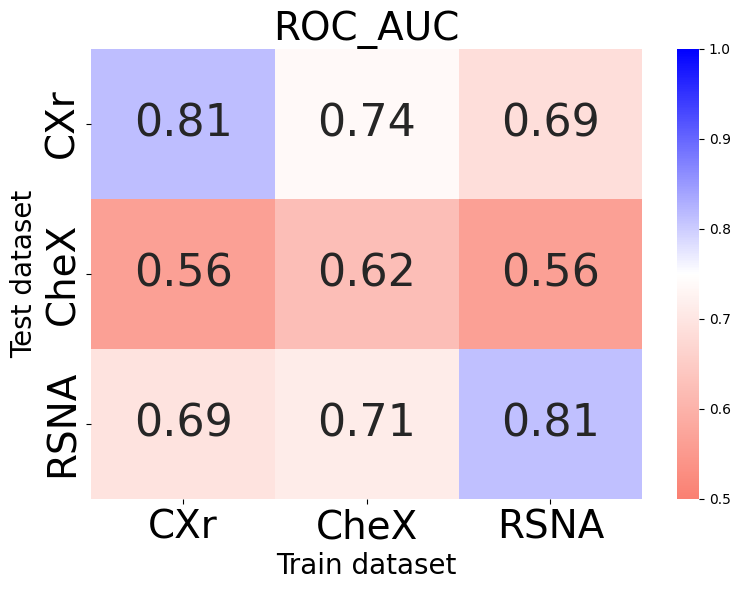

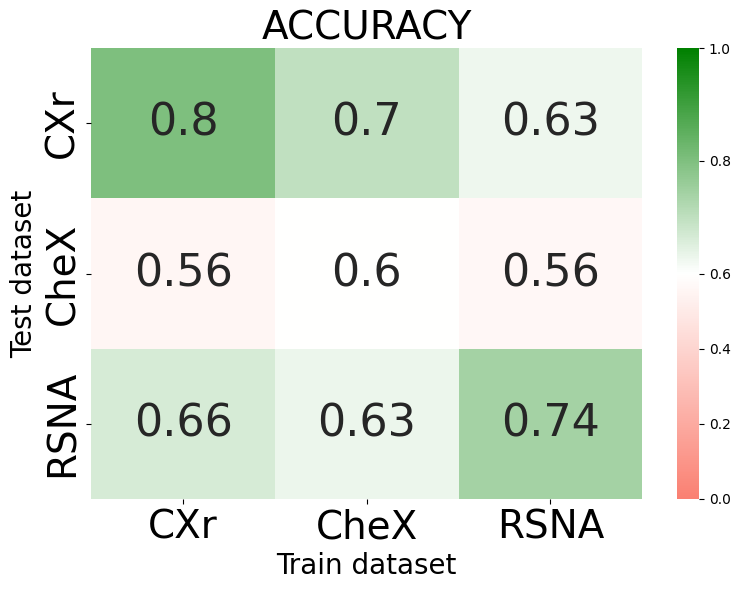

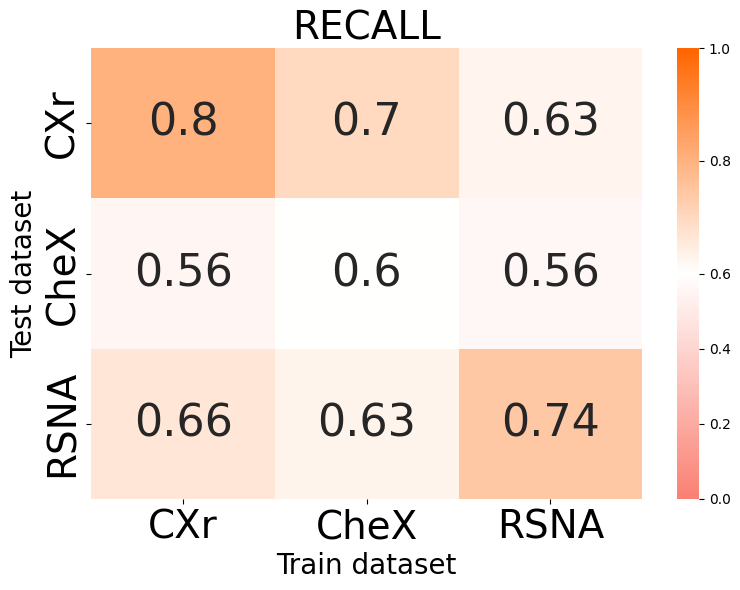

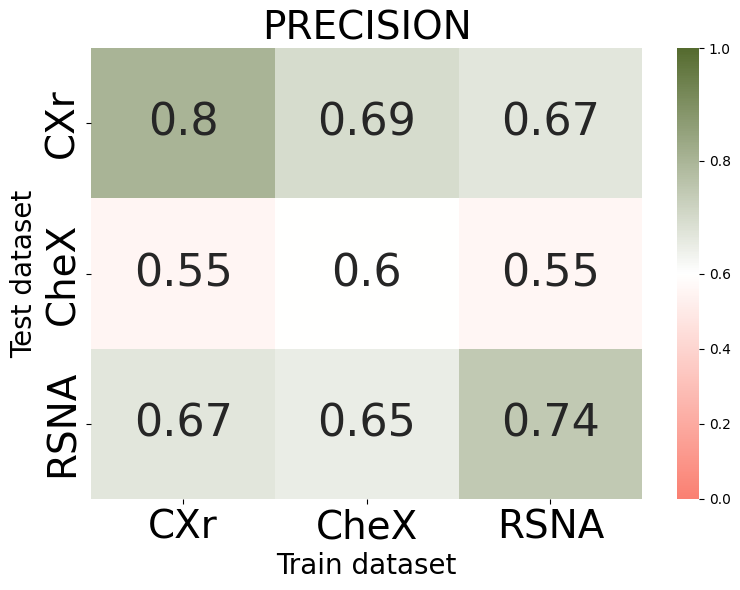

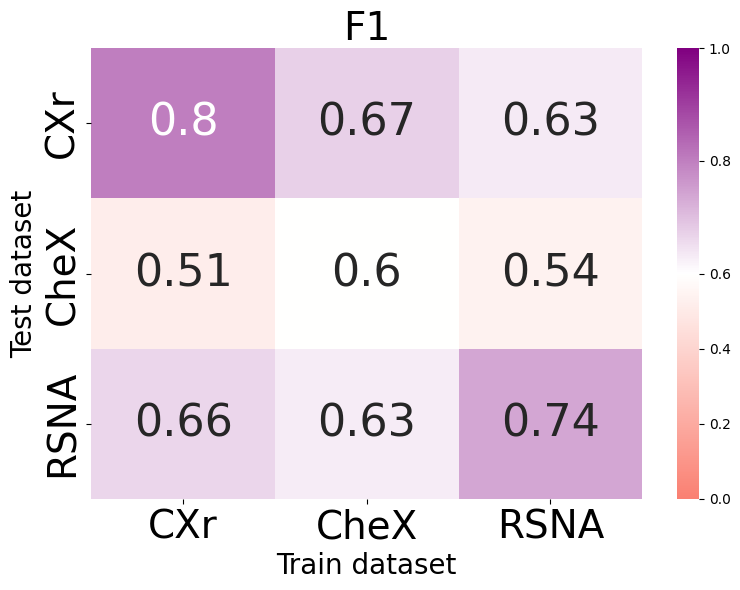

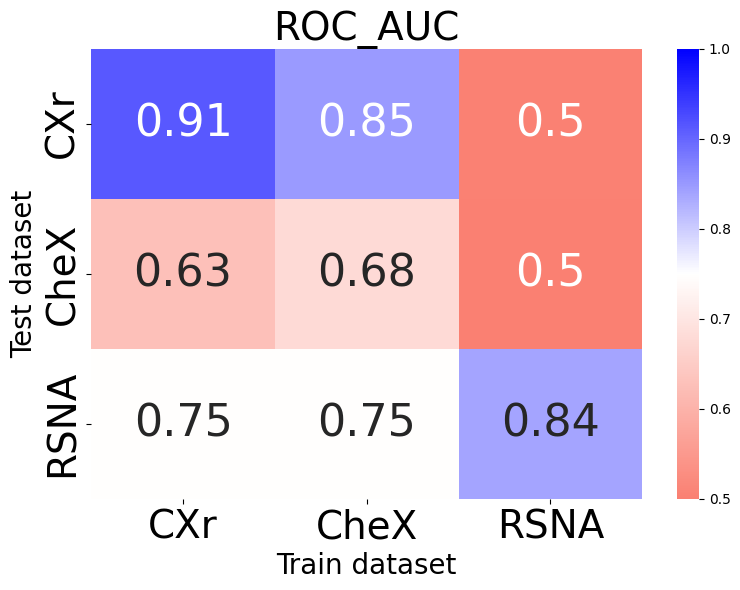

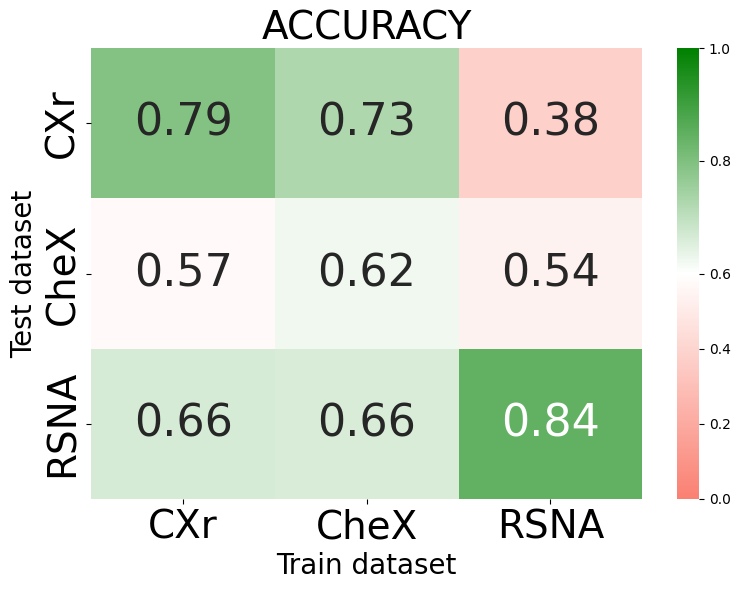

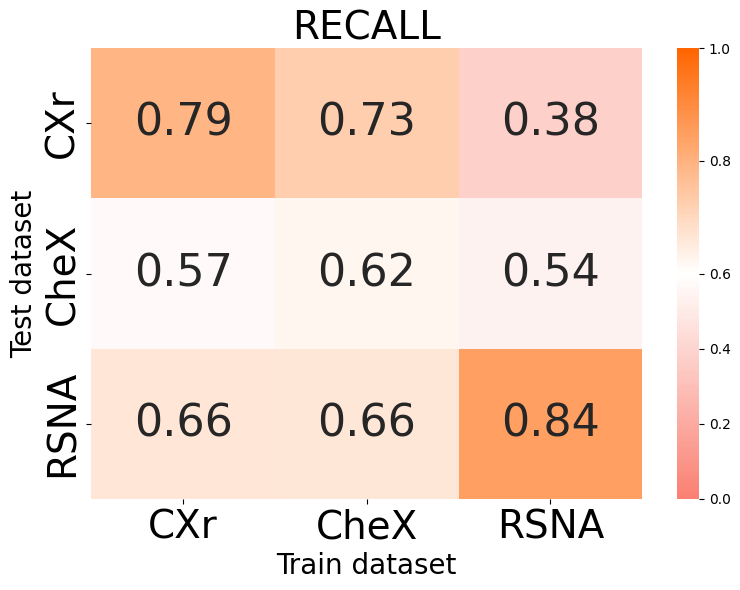

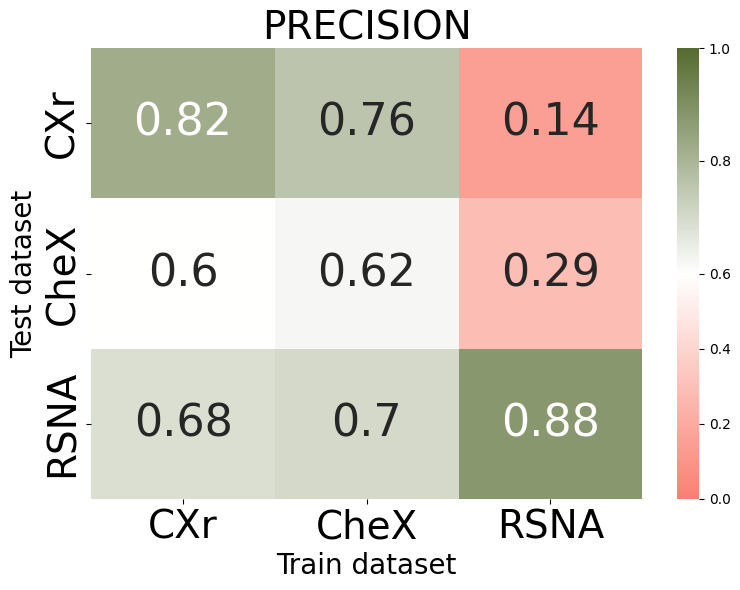

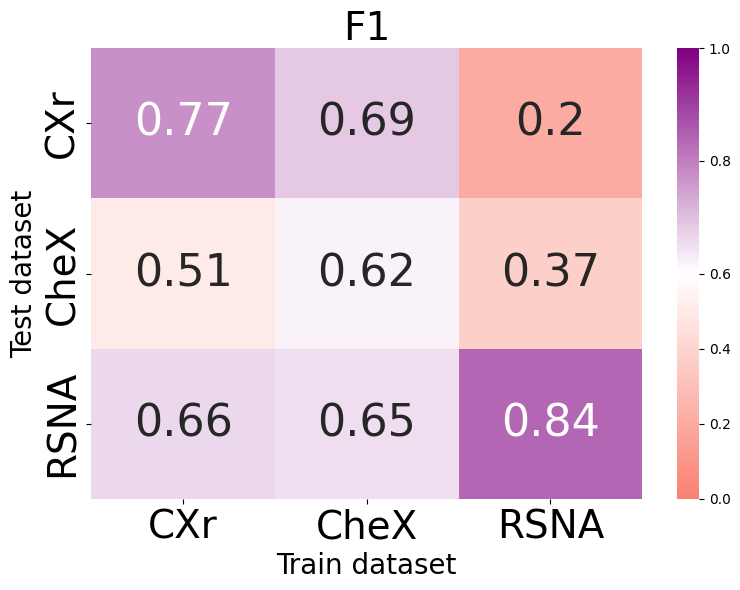

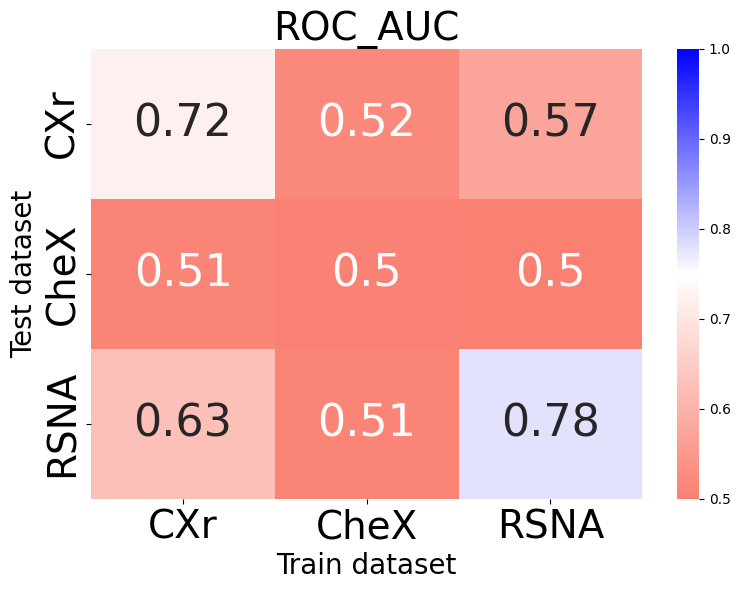

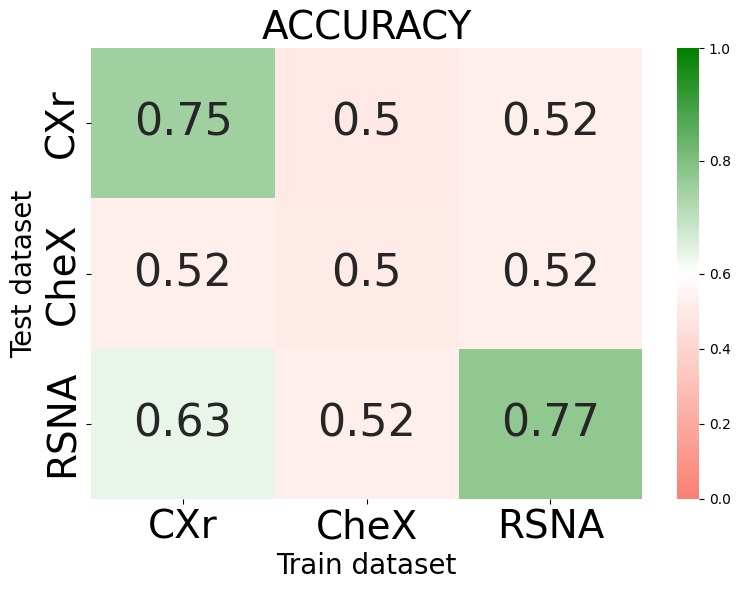

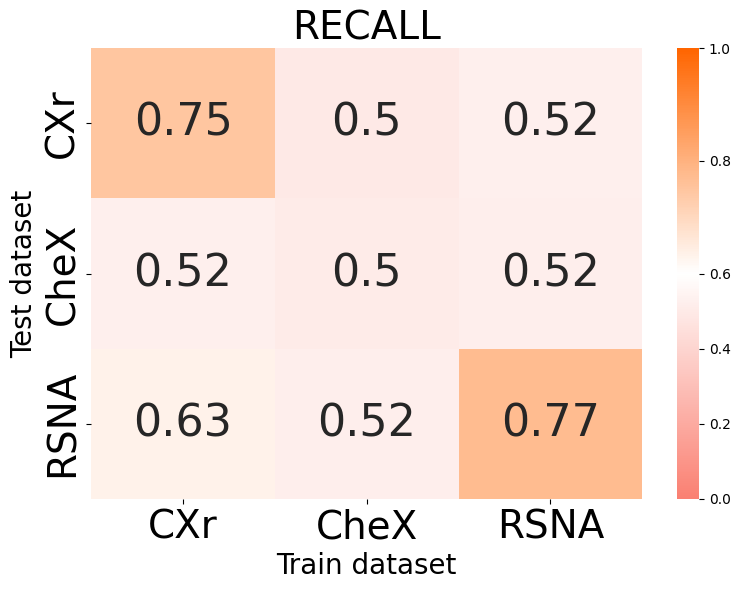

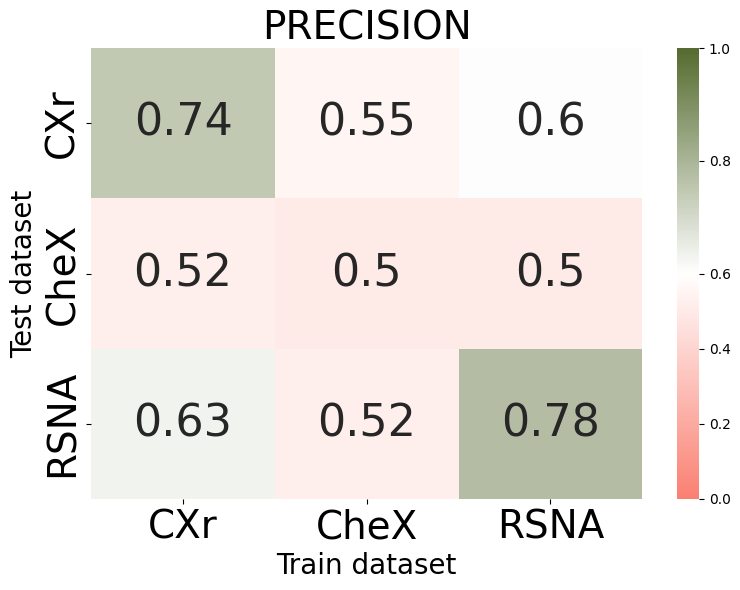

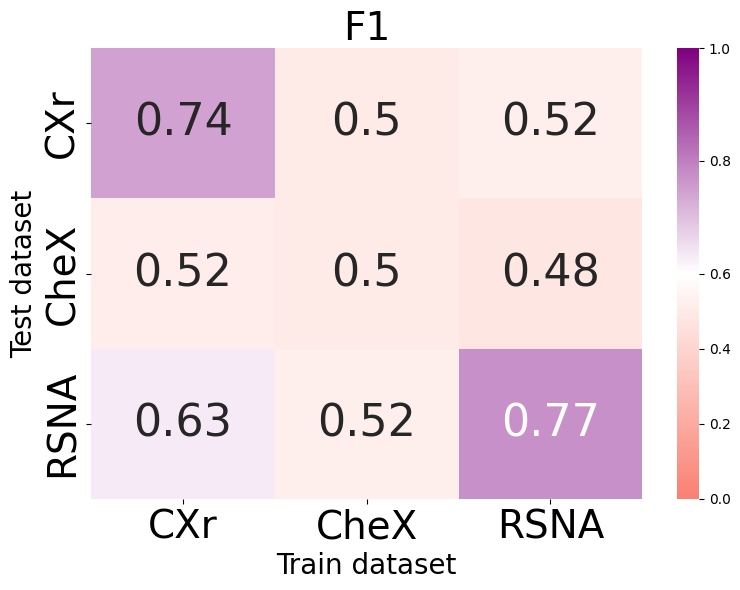

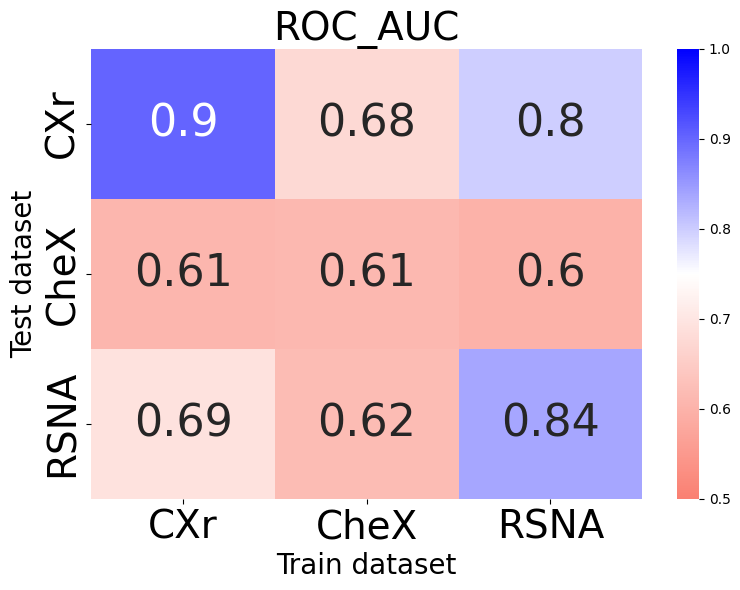

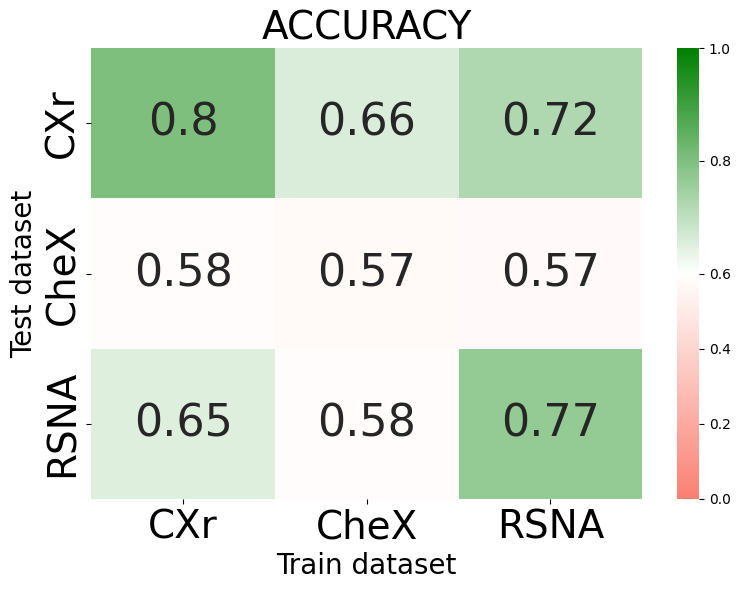

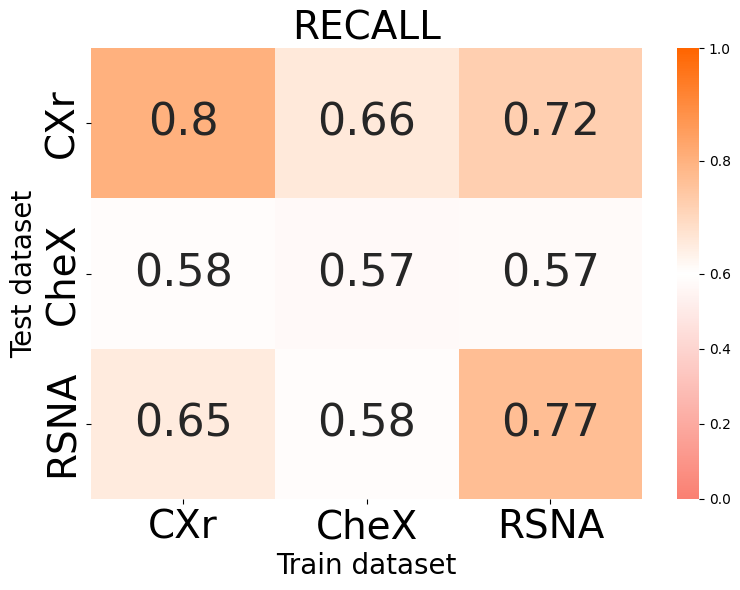

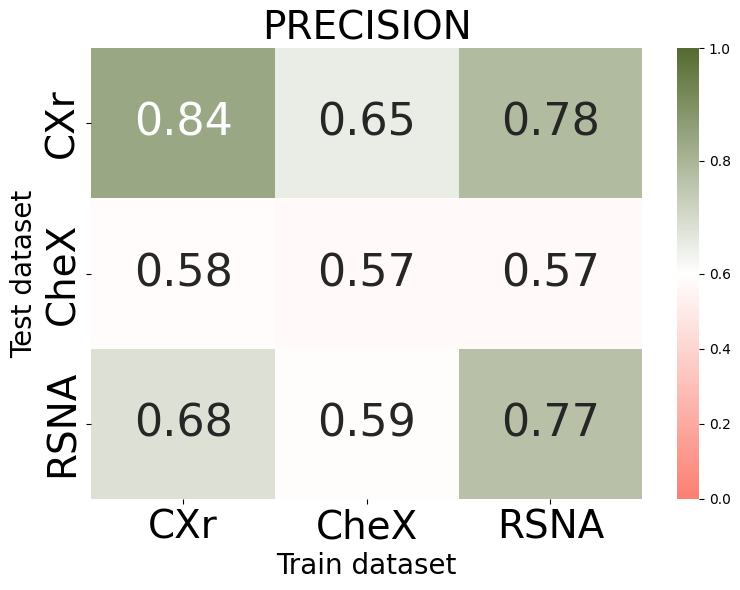

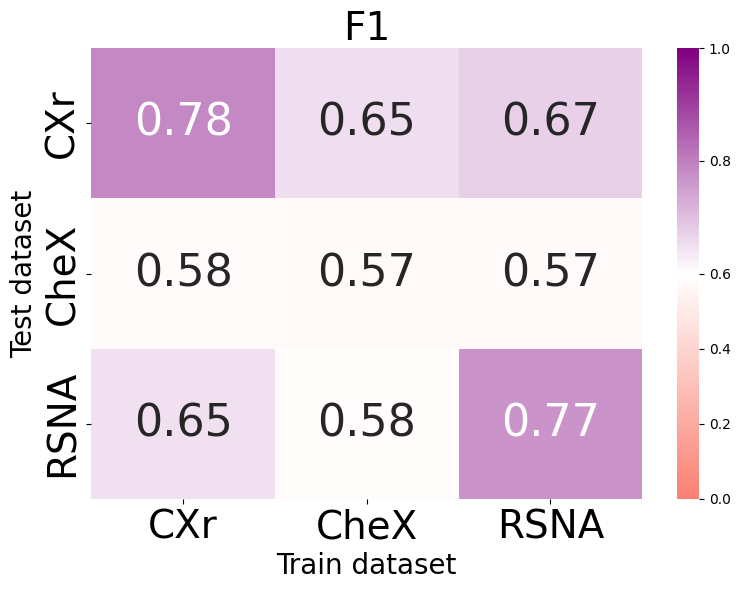

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

blue = LinearSegmentedColormap.from_list("a", ["salmon", "#ffffff", "#0000ff"])
green = LinearSegmentedColormap.from_list("b", ["salmon", "#ffffff", "#008000"])
green_2 = LinearSegmentedColormap.from_list("c", ["salmon", "#ffffff", "#556b2f"])
orange = LinearSegmentedColormap.from_list("d", ["salmon", "#ffffff", "#ff6500"])
purple = LinearSegmentedColormap.from_list("e", ["salmon", "#ffffff", "#800080"])

metric_colormaps = {
    "roc_auc": blue,
    "f1": purple,
    "precision": green_2,
    "recall": orange,
    "accuracy": green
}

# Function to plot all metrics' heatmaps for a single model in one frame
def plot_model_heatmaps_with_colors(dataset_names, datasets, model_name):
    metrics = ["roc_auc", "accuracy", "recall", "precision", "f1"]

    for metric_name in metrics:
        metric_scores = []
        for dataset_test in datasets:
            dataset_scores = []
            for dataset_training in datasets:
                dataset_scores.append(
                    datasets[dataset_training][model_name][dataset_test][metric_name]
                )
            metric_scores.append(dataset_scores)

        # Set vmin and center based on the metric
        if metric_name == 'roc_auc':
            vcenter = 0.75
            vmin = 0.5
        else:
            vcenter = 0.6
            vmin = 0

        divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=1)

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            metric_scores,
            annot=True,
            xticklabels=dataset_names,
            yticklabels=dataset_names,
            cmap=metric_colormaps.get(metric_name, 'coolwarm'),  # Use a default colormap if not specified
            cbar_kws={'label': ""},
            norm=divnorm,
            annot_kws={"size": 32},  # Increase annotation text size
        )
        plt.title(f"{metric_name.upper()}", fontsize=28)  # Increase title font size
        plt.xlabel("Train dataset", fontsize=20)  # Increase x-axis label font size
        plt.ylabel("Test dataset", fontsize=20)  # Increase y-axis label font size
        plt.xticks(fontsize=28)  # Increase x-axis ticks font size
        plt.yticks(fontsize=28)  # Increase y-axis ticks font size
        plt.tight_layout()
        plt.show()

# Generate individual heatmaps for each model
for model_name in ['knn', 'svm', 'dt', 'lr']:
    plot_model_heatmaps_with_colors(dataset_names, datasets, model_name)

#### Comparison of Metric Averages

In [9]:
import numpy as np
def plot_bars(auroc, precision, accuracy, f1, recall, model_name):
    # Function to calculate the means for the same and different dataset
    def calculate_means(metric_data):
        same_dataset = np.diagonal(metric_data)
        different_dataset = metric_data[~np.eye(metric_data.shape[0], dtype=bool)]
        return np.mean(same_dataset), np.mean(different_dataset)

    # Mean values for each metric
    metrics = ["AUROC", "Accuracy", "Recall", "Precision", "F1"]
    values_same = []
    values_different = []

    for metric_data in [auroc, accuracy, recall, precision, f1]:
        mean_same, mean_different = calculate_means(metric_data)
        values_same.append(mean_same)
        values_different.append(mean_different)

    colors_same = ['blue', 'green', 'darkolivegreen', 'orangered', 'purple']
    colors_different = ['lightblue', 'yellowgreen', 'lightgreen', 'lightsalmon', 'violet']

    # Bar chart settings
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(len(metrics)):
        ax.bar(x[i] - width/2, values_same[i], width, color=colors_same[i], label="Stesso Dataset" if i == 0 else None)
        ax.bar(x[i] + width/2, values_different[i], width, color=colors_different[i], label="Dataset Diversi" if i == 0 else None)

    ax.set_ylabel("Average Value for the metric")
    ax.set_title(f"Comparison of Metric Averages for Intra- and Cross-Dataset Evaluations ({model_name})")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)

    legend_labels = ["Training domain only", "All other domains (excl. training)"]
    legend_colors = ['dimgrey', 'darkgrey']
    custom_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i]) for i in range(len(legend_labels))]
    ax.legend(custom_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Plot the figure
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

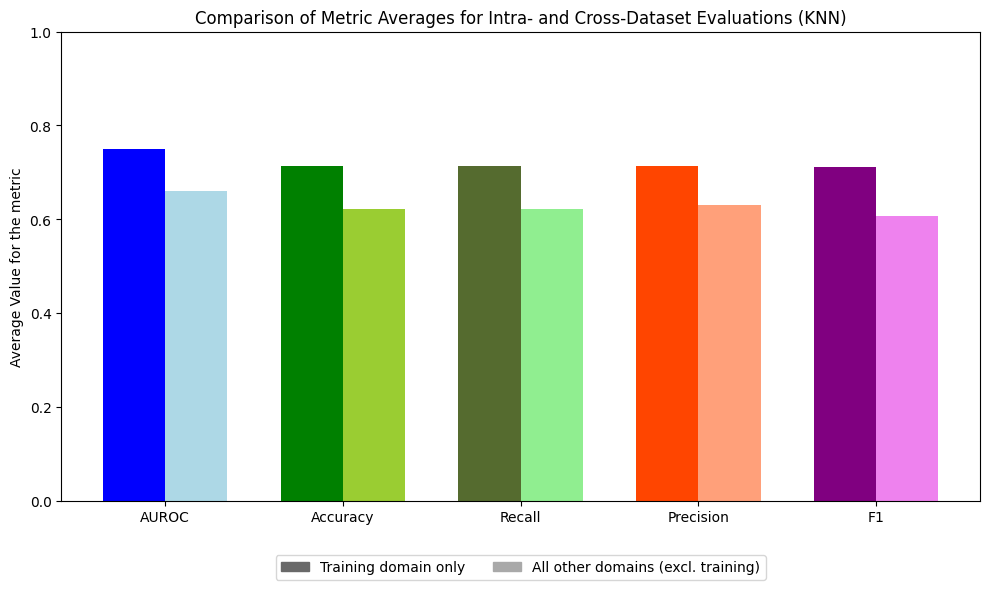

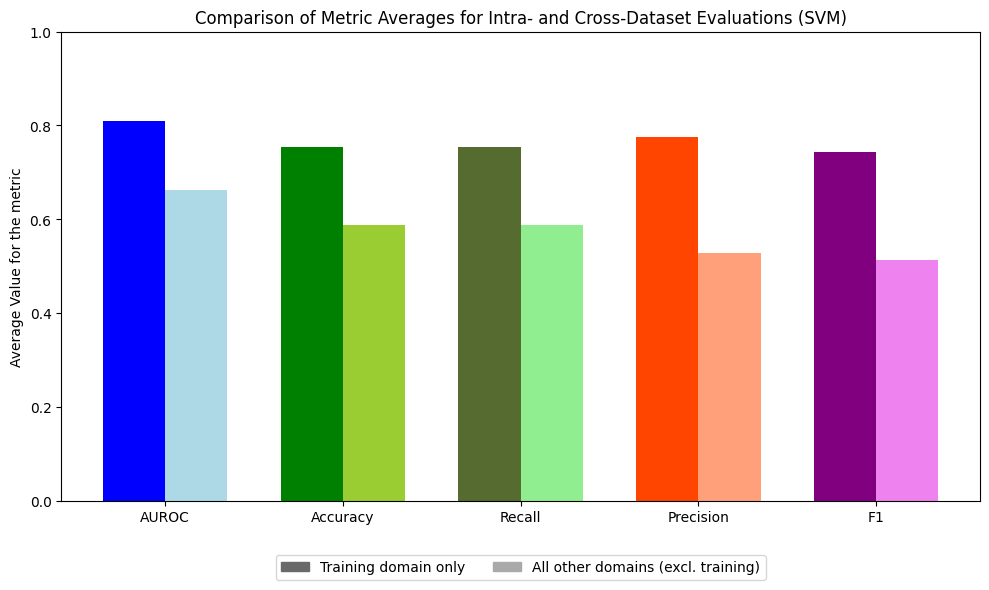

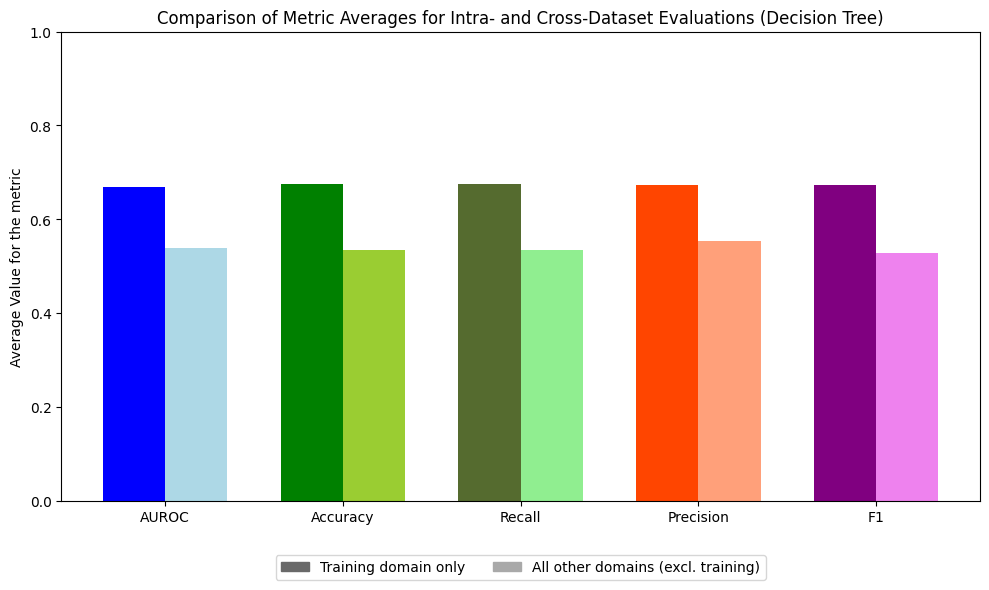

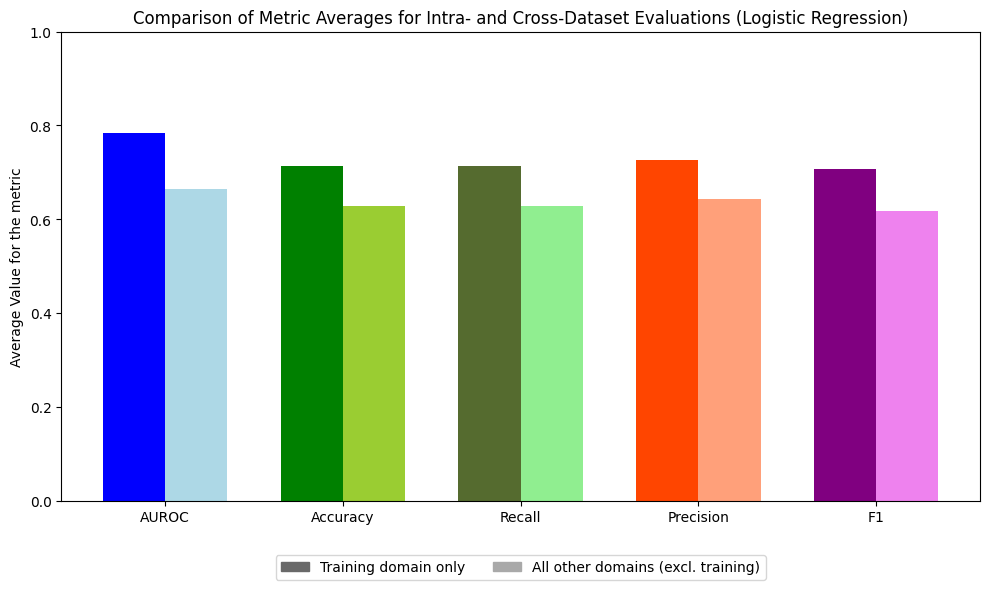

In [12]:
# Initialize empty matrices for each metric
f1 = np.zeros((3, 3))
precision = np.zeros((3, 3))
recall = np.zeros((3, 3))
accuracy = np.zeros((3, 3))
auroc = np.zeros((3, 3))

# List of dataset names to maintain the order
dataset_names = ['CXr', 'RSNA', 'CheX']

# Fill the matrices with corresponding scores
for i, train_dataset in enumerate(dataset_names):
    for j, test_dataset in enumerate(dataset_names):
        knn_metrics = datasets[train_dataset]['knn'][test_dataset]
        f1[i, j] = knn_metrics['f1']
        auroc[i, j] = knn_metrics['roc_auc']
        precision[i, j] = knn_metrics['precision']
        recall[i, j] = knn_metrics['recall']
        accuracy[i, j] = knn_metrics['accuracy']

plot_bars(auroc, precision, accuracy, f1, recall, model_name="KNN")

for i, train_dataset in enumerate(dataset_names):
    for j, test_dataset in enumerate(dataset_names):
        knn_metrics = datasets[train_dataset]['svm'][test_dataset]
        f1[i, j] = knn_metrics['f1']
        auroc[i, j] = knn_metrics['roc_auc']
        precision[i, j] = knn_metrics['precision']
        recall[i, j] = knn_metrics['recall']
        accuracy[i, j] = knn_metrics['accuracy']

plot_bars(auroc, precision, accuracy, f1, recall, model_name="SVM")

for i, train_dataset in enumerate(dataset_names):
    for j, test_dataset in enumerate(dataset_names):
        knn_metrics = datasets[train_dataset]['dt'][test_dataset]
        f1[i, j] = knn_metrics['f1']
        auroc[i, j] = knn_metrics['roc_auc']
        precision[i, j] = knn_metrics['precision']
        recall[i, j] = knn_metrics['recall']
        accuracy[i, j] = knn_metrics['accuracy']

plot_bars(auroc, precision, accuracy, f1, recall, model_name="Decision Tree")

for i, train_dataset in enumerate(dataset_names):
    for j, test_dataset in enumerate(dataset_names):
        knn_metrics = datasets[train_dataset]['lr'][test_dataset]
        f1[i, j] = knn_metrics['f1']
        auroc[i, j] = knn_metrics['roc_auc']
        precision[i, j] = knn_metrics['precision']
        recall[i, j] = knn_metrics['recall']
        accuracy[i, j] = knn_metrics['accuracy']

plot_bars(auroc, precision, accuracy, f1, recall, model_name="Logistic Regression")

##### PCA Analisys

Number of PCA components for CXr: 2682


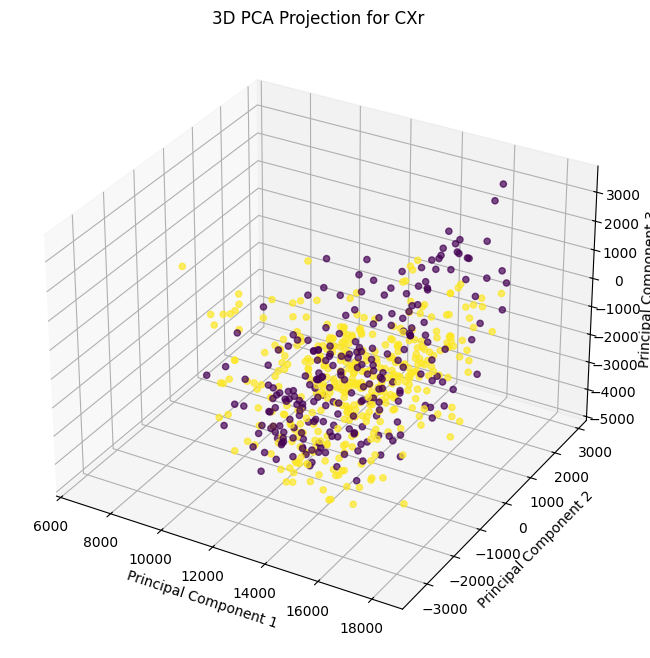

Number of PCA components for CheX: 3804


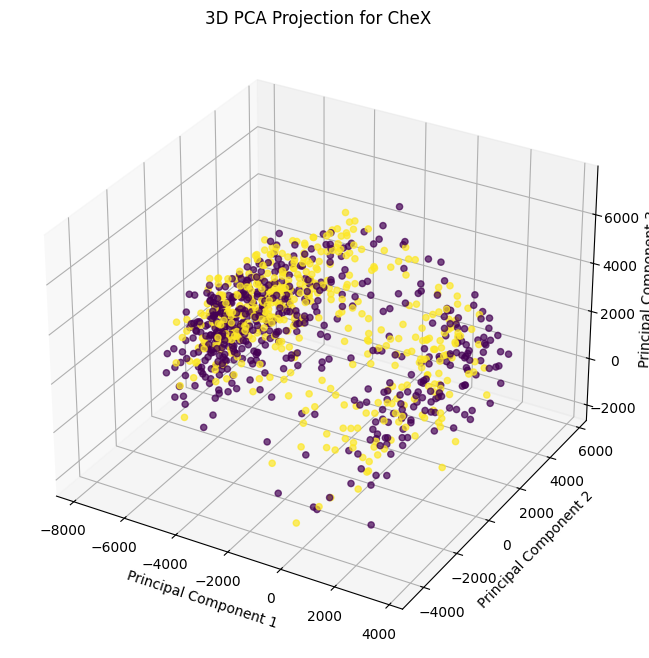

Number of PCA components for RSNA: 3814


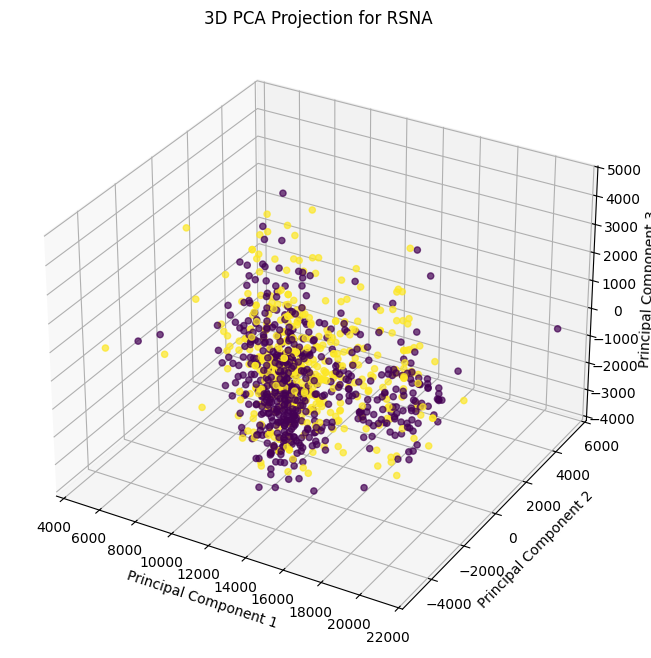

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for dataset_name in dataset_names:
    if dataset_name in models:
        pipeline = models[dataset_name]
        pca = pipeline.named_steps['pca']

        if pca.n_components_ < 3:
            print(f"PCA for {dataset_name} has less than 3 components. Skipping 3D plot.")
            continue

        print(f"Number of PCA components for {dataset_name}: {pca.n_components_}")

        X_test_pca = pca.transform(datasets[dataset_name]['X_test'])
        y_test = datasets[dataset_name]['y_test']

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            X_test_pca[:, 0],
            X_test_pca[:, 1],
            X_test_pca[:, 2],
            c=y_test,
            cmap='viridis',
            alpha=0.7
        )
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title(f'3D PCA Projection for {dataset_name}')
        plt.show()
